- Import Packages

In [238]:
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import math

- Load Dataset

In [239]:
# path = r"C:\Users\moaxs\Desktop\REU 2025\PDM Project\Code\Greedy Model\job_data.json"
path = "../../Input_Data/job_data.json"
with open(path, 'r') as file: 
    data = json.load(file)

- Simple Parameters

In [240]:
sample_size = 700
start_time = 0
end_time = 1400
max_length = 500

- Greedy Jobs

In [241]:
# Take a random sample of jobs
jobs_array = data['jobs']
random.shuffle (jobs_array)

# List is same length of sample size
flexibility_array = []

i = 0
curr_index = 0
while (i < sample_size) :
    rj = jobs_array[curr_index]['release']
    dj = jobs_array[curr_index]['deadline']
    lj = jobs_array[curr_index]['length']

    fj = dj - rj - lj

    # Check if the specific job lies within the correct window
    # The funky syntax is used to put the job id at the very front of the dictionary
    if rj >= start_time and dj <= end_time and lj <= max_length:
        flexible_id = {'flexible_id': i}
        flexibility = {'flexibility': fj}
        flexible_object = {**flexible_id, **flexibility, **jobs_array[curr_index]}
        flexibility_array.append(flexible_object)

        i += 1
    
    curr_index += 1

flexible = sorted(flexibility_array, key=lambda job: job['flexibility']) 

print(flexible)
print(len(flexible))

[{'flexible_id': 379, 'flexibility': 11, 'release': 650, 'deadline': 891, 'length': 230, 'height': 119.19}, {'flexible_id': 559, 'flexibility': 13, 'release': 976, 'deadline': 1063, 'length': 74, 'height': 330.46}, {'flexible_id': 96, 'flexibility': 14, 'release': 848, 'deadline': 923, 'length': 61, 'height': 1691.57}, {'flexible_id': 236, 'flexibility': 16, 'release': 541, 'deadline': 565, 'length': 8, 'height': 351.31}, {'flexible_id': 140, 'flexibility': 17, 'release': 1072, 'deadline': 1100, 'length': 11, 'height': 513.48}, {'flexible_id': 368, 'flexibility': 17, 'release': 779, 'deadline': 824, 'length': 28, 'height': 728.48}, {'flexible_id': 369, 'flexibility': 17, 'release': 455, 'deadline': 889, 'length': 417, 'height': 329.81}, {'flexible_id': 434, 'flexibility': 18, 'release': 843, 'deadline': 897, 'length': 36, 'height': 45.65}, {'flexible_id': 601, 'flexibility': 18, 'release': 522, 'deadline': 553, 'length': 13, 'height': 991.5}, {'flexible_id': 148, 'flexibility': 19, 're

- Resource Curve

In [242]:
# Instantiate the resource curve
path = "../../Input_Data/solar_data.json"
with open(path, 'r') as file: 
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 3
resources = total[(24 * day) + start_time : (24 * day) + end_time]

scale_factor = 4.233
resources = [r * scale_factor for r in resources]

- Find All Possible Start Times for Each Job

In [243]:
intervals = [[] for _ in range(len(flexible))]
for i, job in enumerate(flexible):
    # Extract the necessary information from the job object
    release = job['release'] - start_time
    deadline = job['deadline'] - start_time
    duration = job['length']
    num = release

    # Add the execution intervals to the sublist
    while (num + duration <= deadline):
        intervals[i].append((num, num + duration))
        num += 1

- Definitions

In [244]:
# Iterate through the jobs and add their corresponding heights
height = [job['height'] for job in flexible]

# Specify the number of time steps 
num_time_steps = end_time - start_time

- Label each job and possible interval combination

In [245]:
decision_variables = []
for j, interval_set in enumerate(intervals):
    for i, interval in enumerate(interval_set):
        # Add the decision variable and it's corresponding interval to the list
        decision_variables.append({'name' : f'x_{i}_{j}', 'value': interval})

# This is the name of the objective variable that we will minimize
objective_variable = 'd'

- Find best interval for each job

In [246]:
final_greedy_heights = [0 for _ in range(num_time_steps)]
final_greedy_heights_2 = [0 for _ in range(num_time_steps)]
for job_id, interval_set in enumerate(intervals):
    best_score = float(-math.inf)
    best_interval = None

    best_score_2 = float(math.inf)
    best_interval_2 = None

    job_height = flexible[job_id]['height']

    for interval in interval_set:
        interval_start, interval_end = interval[0], interval[1]

        # this is measuring the total area oabove the curve
        score = sum([resources[i] - final_greedy_heights[i] - job_height for i in range(interval_start, interval_end)])

        # We want to find the max of this array above
        # because we are more concerned right now with PDAC
        score_2 = max([resources[i] - final_greedy_heights_2[i] - job_height for i in range(interval_start, interval_end)])

        if score > best_score:
            best_score = score
            best_interval = interval

        if score_2 < best_score_2:
            best_score_2 = score_2
            best_interval_2 = interval
    
    for i in range(best_interval[0], best_interval[1]):
        final_greedy_heights[i] += job_height
    
    for i in range(best_interval_2[0], best_interval_2[1]):
        final_greedy_heights_2[i] += job_height 


- Final Heights for Each Job Interval

- Plot jobs

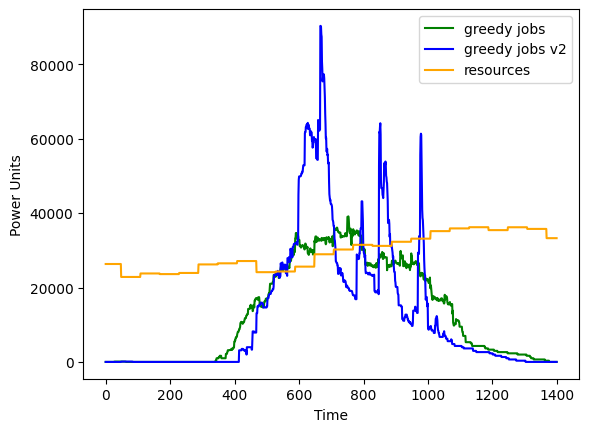

In [247]:
job_graph_xvalues = np.array([i for i in range(start_time, end_time)])

plt.plot(job_graph_xvalues, final_greedy_heights, label="greedy jobs", color='green')
plt.plot(job_graph_xvalues, final_greedy_heights_2, label="greedy jobs v2", color='blue')
plt.plot(job_graph_xvalues, resources, label='resources', color='orange')

plt.xlabel("Time")
plt.ylabel("Power Units")
plt.legend()
plt.show()